# ANFIS classifier
***
A three label classifier for market behavior prediction based on Jang's original ANFIS architecture

## LUISS 'Guido Carli' - A.Y. 2023-24  
Machine Learning Project Submission

Marchioni Gian Lorenzo - Paquette David - Tomasella Elena
***

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import utilities
# utilities.py file contains functions for calculations and plots

import sys
sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis_gian')

import anfis
import membership 
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nolds

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
msft = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Microsoft_weekly_ok.csv', 
                   index_col=False, 
                   parse_dates=['Date'])
amzn = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', 
                   index_col=False, 
                   parse_dates=['Date'])
ibm = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\IBM_weekly_ok.csv', 
                  index_col=False, 
                  parse_dates=['Date'])
cac = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Cac_weekly_ok.csv', 
                  index_col=False, 
                  parse_dates=['Date'])
sp500 = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Sp500_weekly_ok.csv', 
                    index_col=False, 
                    parse_dates=['Date'])
nasdaq = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Nasdaq_weekly_ok.csv', 
                     index_col=False, 
                     parse_dates=['Date'])

In [3]:
dfs = [amzn, cac, ibm, msft, nasdaq, sp500]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)

    df_name =[x for x in globals() if globals()[x] is df][0]
    print(f'Indicator parameters for {df_name}:')

    # Perform Grid Search to look for indicator parameters that maximize Hurst Exponent
    hurst_results_df=utilities.grid_search_hurst(df)
    print(hurst_results_df)
    print('─' * 77)
    
    # Access parameters for the indicators from the hurst_results_df
    rsi_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'RSI', 'Best Period'].values[0]
    cci_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'CCI', 'Best Period'].values[0]
    ema_short_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'EMADN', 'Best Short Period'].values[0]
    ema_long_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'EMADN', 'Best Long Period'].values[0]
    cpc_window = hurst_results_df.loc[hurst_results_df['Indicator'] == 'CPC', 'Best Period'].values[0]
        
    # Now use these values to calculate the indicators
    # Note that 'Best Short Period'  and  'Best Long Period' only applies for EMADN,
    # as it is the difference between two EMAs. 
    # The other indicators just have one parameter.
    df=utilities.calculate_indicators(df, 
                         rsi_period=rsi_period,
                         cci_period=cci_period, 
                         ema_short_period=ema_short_period, 
                         ema_long_period=ema_long_period, 
                         cpc_window=cpc_window)

    # Compute the weekly returns
    # Assign to each week the next one's return and convert it into the target variable (+1, 0, -1)
    # Target will be the categorical 'Next_week_market_behavior'
    df=utilities.preprocess_market_behavior(df)    

Indicator parameters for amzn:
  Indicator  Best Period  Hurst Exponent  Best Short Period  Best Long Period
0       CCI           36            0.90               <NA>              <NA>
1     EMADN         <NA>            0.92                 24                52
2       CPC           39            0.99               <NA>              <NA>
3       RSI           38            0.96               <NA>              <NA>
─────────────────────────────────────────────────────────────────────────────
Indicator parameters for cac:
  Indicator  Best Period  Hurst Exponent  Best Short Period  Best Long Period
0       CCI           38            0.91               <NA>              <NA>
1     EMADN         <NA>            0.94                 24                58
2       CPC           37            1.01               <NA>              <NA>
3       RSI           37            0.97               <NA>              <NA>
─────────────────────────────────────────────────────────────────────────────
Ind

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

In [4]:
amzn.head(5)

,Date,Open,High,Low,Close,RSI,CCI,EMADN,CPC,Current_week_pct_change,Next_week_pct_change,Next_week_market_behavior
0,1998-09-27,0.633333,0.973958,0.633333,0.910420,63.689204,73.116444,0.338982,1.0,37.098025,0.914962,1
1,1998-10-04,0.969792,1.000000,0.833333,0.918750,64.744361,86.670801,0.333435,1.0,0.914962,-17.290340,-1
2,1998-10-11,0.907292,0.935417,0.666667,0.759895,60.301088,48.334561,0.318557,1.0,-17.290340,9.047303,1
3,1998-10-18,0.809375,0.849479,0.747917,0.828645,61.244236,49.218548,0.308201,1.0,9.047303,16.782217,1
4,1998-10-25,0.825000,0.985938,0.825000,0.967710,63.245437,72.667787,0.305449,1.0,16.782217,8.880243,1


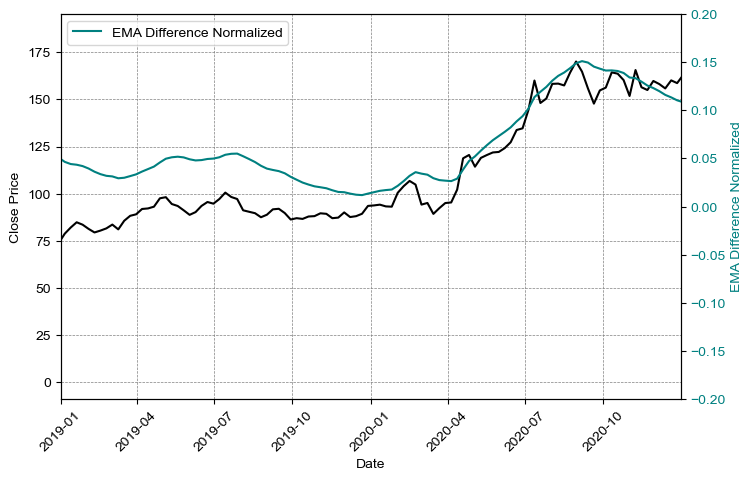

In [5]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['EMADN'], color='#008080', label='EMA Difference Normalized')
ax2.set_ylabel('EMA Difference Normalized', color='#008080')
ax2.tick_params(axis='y', labelcolor='#008080')
ax2.set_ylim([-0.2, 0.2])
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('EMADN.png', transparent=True)
plt.show()

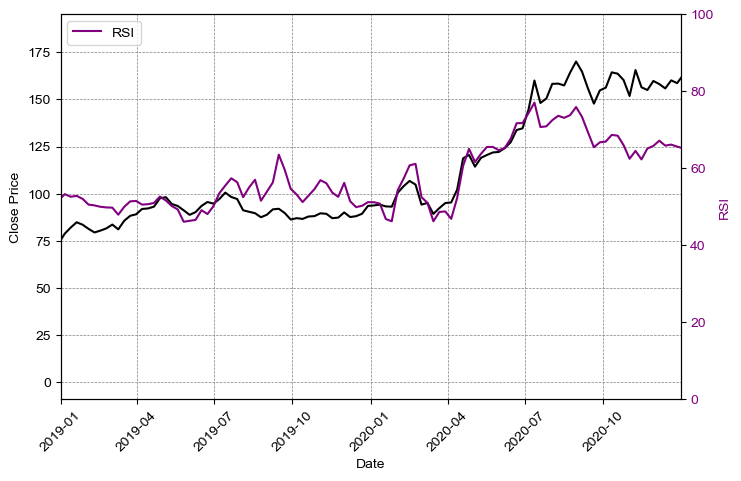

In [6]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='#800080', label='RSI')
ax2.set_ylabel('RSI', color='#800080')
ax2.set_ylim([0, 100])
ax2.tick_params(axis='y', labelcolor='#800080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('RSI.png', transparent=True)
plt.show()

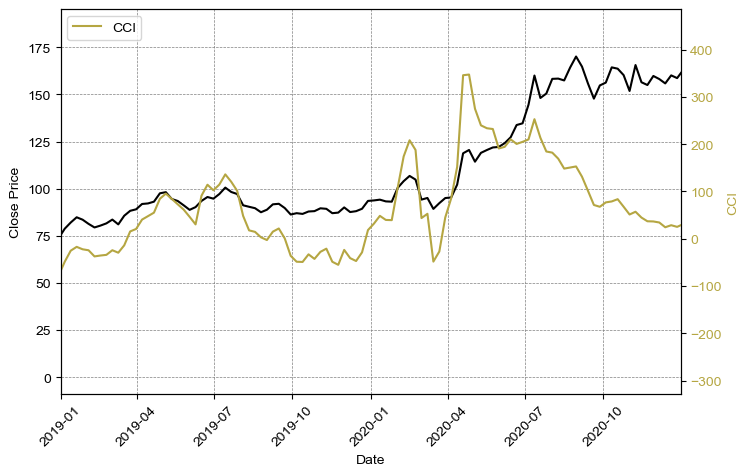

In [7]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='#B5A642', label='CCI')
ax2.set_ylabel('CCI', color='#B5A642')
ax2.tick_params(axis='y', labelcolor='#B5A642')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CCI.png', transparent=True)

plt.show()

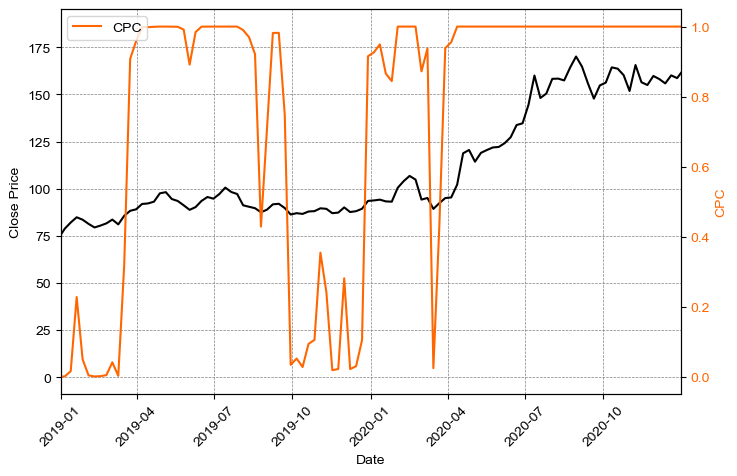

In [8]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='#FF6600', label='CPC')
ax2.set_ylabel('CPC', color='#FF6600')
ax2.tick_params(axis='y', labelcolor='#FF6600')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CPC.png', transparent=True)

plt.show()

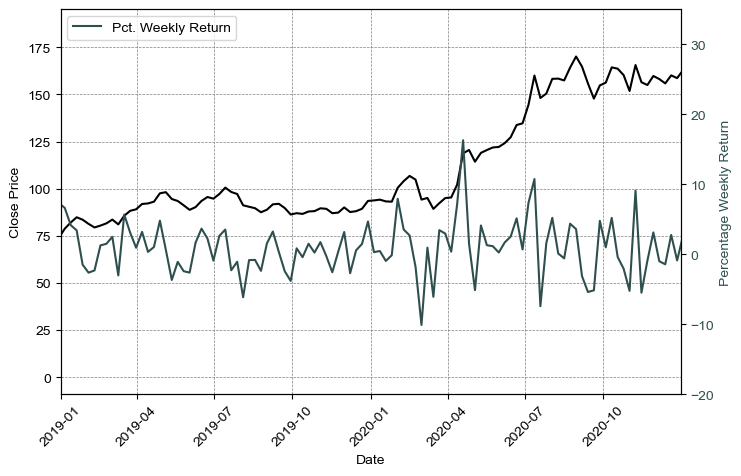

In [9]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['Current_week_pct_change'], color='#2F4F4F', label='Pct. Weekly Return')
ax2.set_ylabel('Percentage Weekly Return', color='#2F4F4F')
ax2.set_ylim([-20, 35])
ax2.tick_params(axis='y', labelcolor='#2F4F4F')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('PercentageReturn.png', transparent=True)

plt.show()

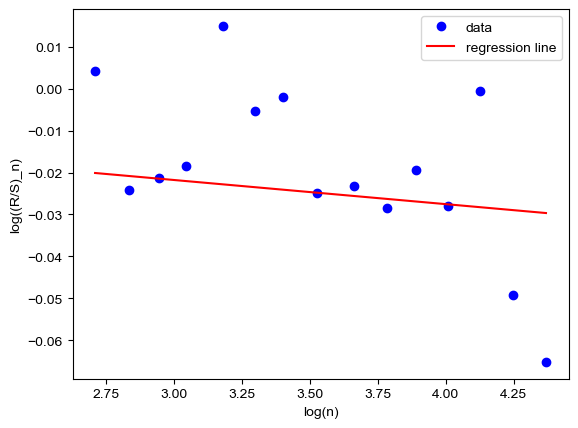

Hurst exponent (R/S estimate) for Weekly Return series: 0.49


In [10]:
H_rs=nolds.hurst_rs(data=amzn['Current_week_pct_change'], debug_plot=True)
print("Hurst exponent (R/S estimate) for Weekly Return series:", round(H_rs,2))

***
# Training and Validation
The model is trained on each dataset uning a 90-10 split. After each training, it will be cross-tested using the other test sets.

In [11]:
# Define your feature columns
feature_columns = ['RSI', 'CCI', 'CPC', 'EMADN', 'Current_week_pct_change']

# Define the membership functions for RSI and store in invars:
invars = [
    ('RSI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CCI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CPC', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('EMADN', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('RETURN',[
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ])
]

# Instance the anfis classifier model, specifying the number of output classes
model = anfis.AnfisNetClassifier(invardefs=invars, num_classes=3)

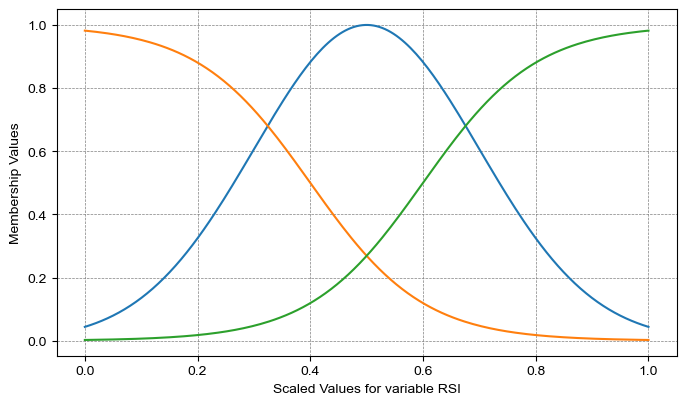

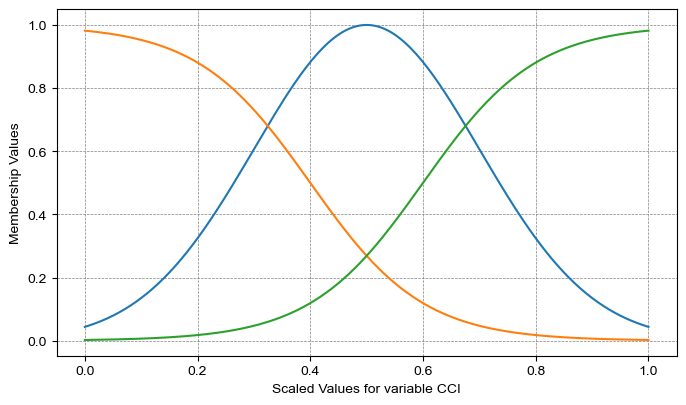

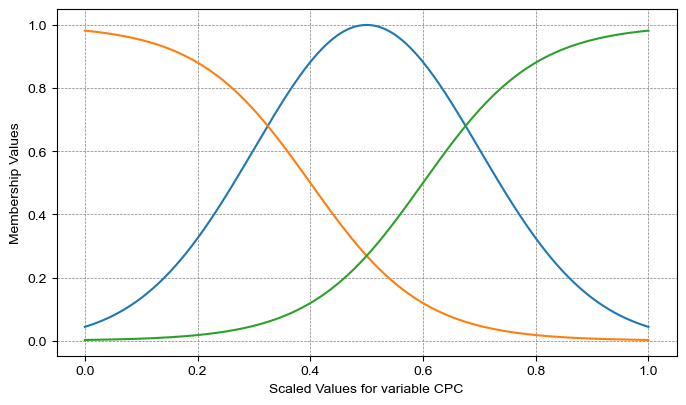

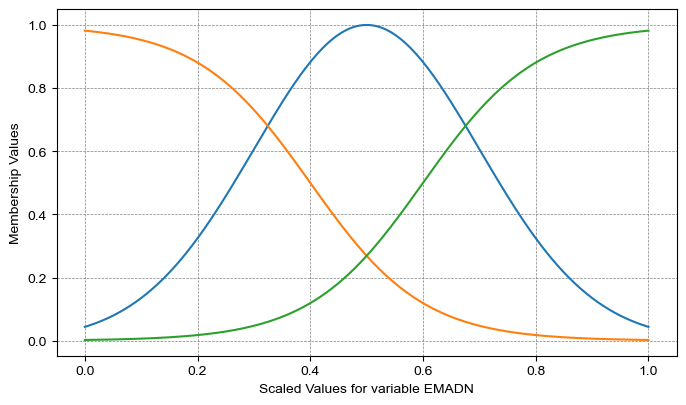

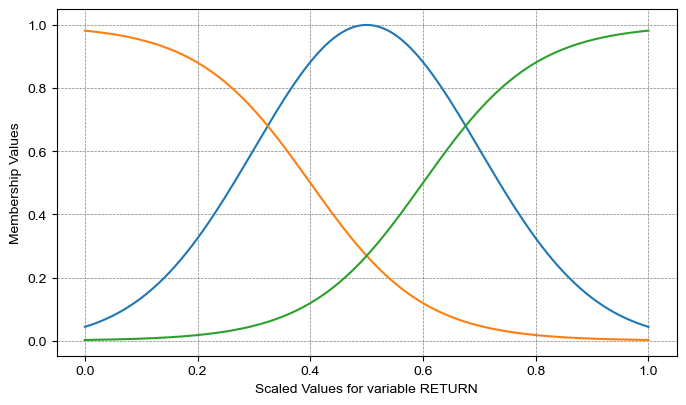

Initial Membership Functions:


In [12]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)
experimental.plot_all_mfs(model, x)
print('Initial Membership Functions:')

***
## AMZN dataset

### Training for 500 epochs, training size = 1194 cases
epoch    0: Loss=1.09786
epoch   10: Loss=0.94360
epoch   20: Loss=0.92563
epoch   30: Loss=0.92054
epoch   40: Loss=0.91775
epoch   50: Loss=0.91581
epoch   60: Loss=0.91387
epoch   70: Loss=0.91165
epoch   80: Loss=0.90957
epoch   90: Loss=0.90760
epoch  100: Loss=0.90579
epoch  110: Loss=0.90411
epoch  120: Loss=0.90257
epoch  130: Loss=0.90116
epoch  140: Loss=0.89985
epoch  150: Loss=0.89861
epoch  160: Loss=0.89742
epoch  170: Loss=0.89626
epoch  180: Loss=0.89509
epoch  190: Loss=0.89391
epoch  200: Loss=0.89275
epoch  210: Loss=0.89164
epoch  220: Loss=0.89058
epoch  230: Loss=0.88958
epoch  240: Loss=0.88858
epoch  250: Loss=0.88743
epoch  260: Loss=0.88643
epoch  270: Loss=0.88547
epoch  280: Loss=0.88455
epoch  290: Loss=0.88364
epoch  300: Loss=0.88281
epoch  310: Loss=0.88200
epoch  320: Loss=0.88128
epoch  330: Loss=0.88059
epoch  340: Loss=0.87996
epoch  350: Loss=0.87938
epoch  360: Loss=0.87884
epoch  370: Loss=0.

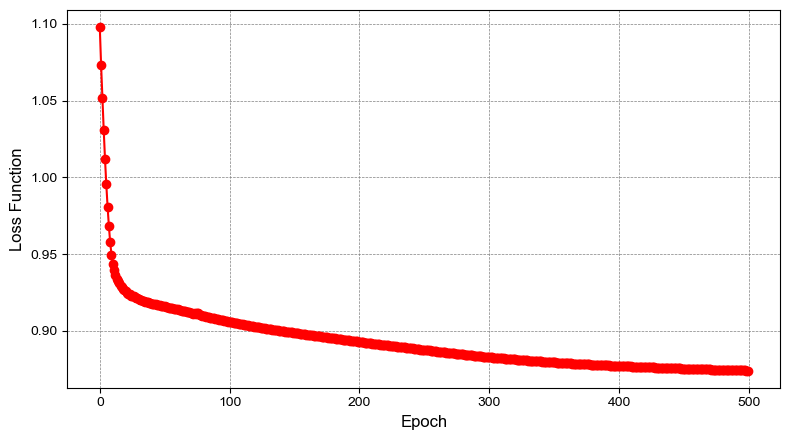

In [13]:
df=amzn
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 53.0 %
────────────────────────────────────────


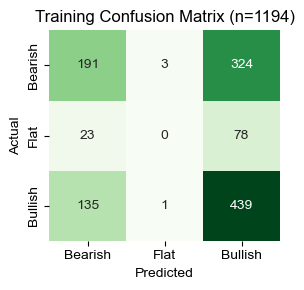

In [14]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 48.0 %
────────────────────────────────────────


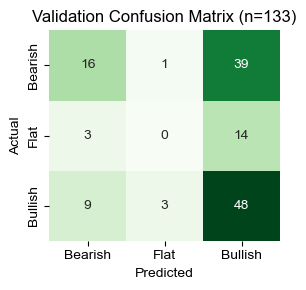

In [15]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

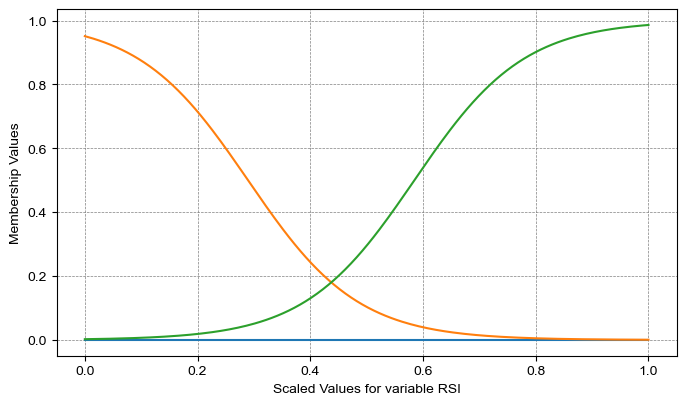

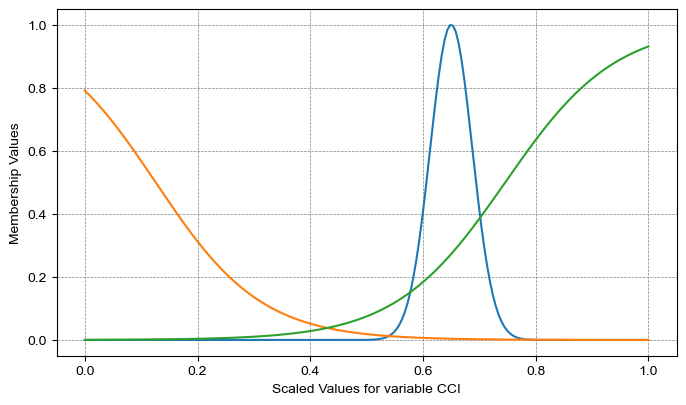

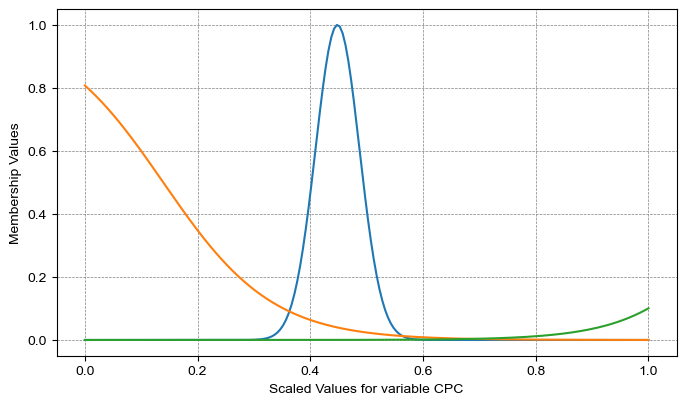

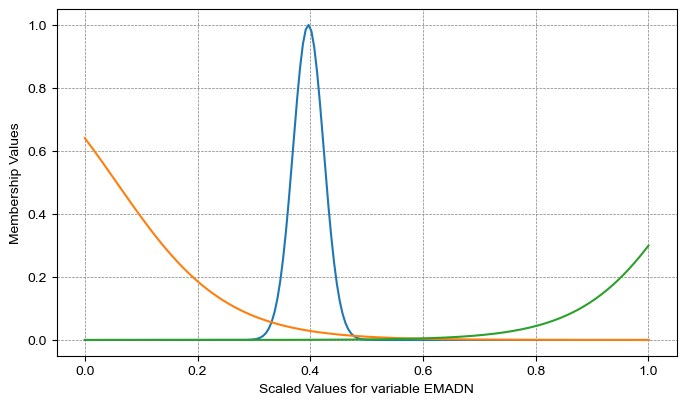

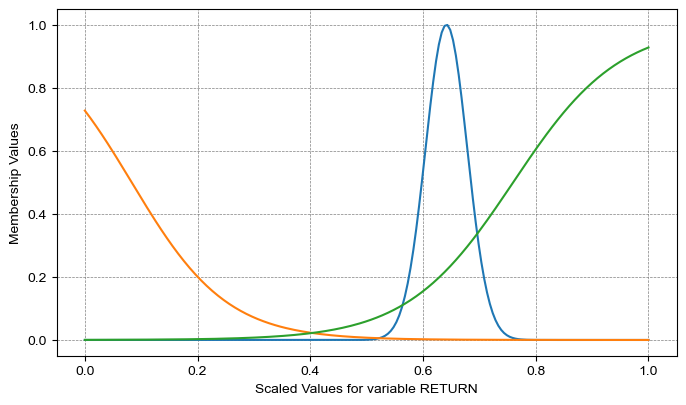

Membership Functions after training:


In [16]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)
experimental.plot_all_mfs(model, x)
print('Membership Functions after training:')

Cumulative return over the period: 94450.4 %
Baseline Return (Buy and Hold over the period): 19120.8 %
Maximum Drawdown Duration 365 weeks


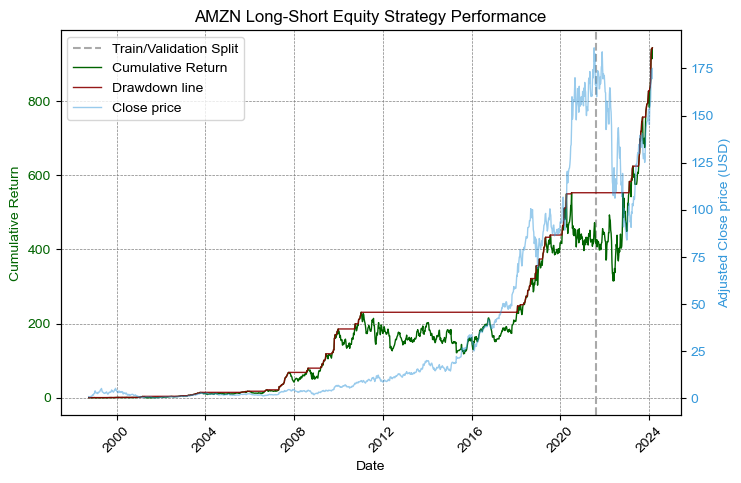

In [17]:
# Combine predictions into a single column
amzn['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

amzn=utilities.calculate_returns(amzn, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(amzn, 'AMZN', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 127.1 %
Baseline Return (Buy and Hold over the period): 6.2 %
Validation Set Maximum Drawdown: 31 weeks


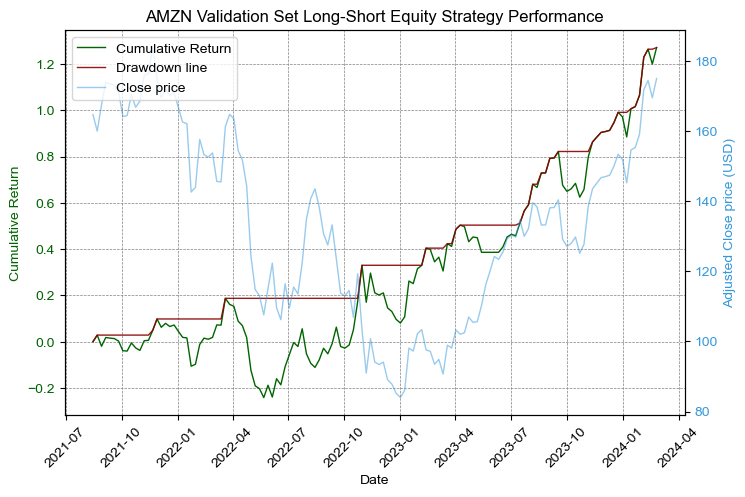

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -9.3 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 20 weeks
────────────────────────────────────────
Cumulative return over the period: 89.1 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 14 weeks
────────────────────────────────────────


In [18]:
split_idx=int(len(amzn)*0.9)
amzn_test_df=amzn[split_idx:]
amzn_test_df = utilities.calculate_returns(amzn_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(amzn_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(amzn_test_df, 'AMZN Validation Set', save_figure=True)
utilities.calculate_yearly_returns(amzn_test_df)

Cross-testing on IBM Test
Cross-Test Accuracy: 39.0 %
────────────────────────────────────────
Cumulative return over the period: 18.7 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 20 weeks
────────────────────────────────────────


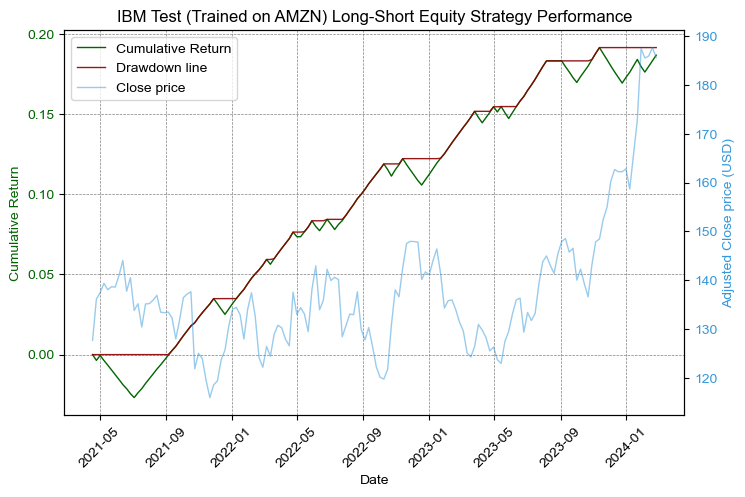

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 6.9 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 20 weeks
────────────────────────────────────────
Cumulative return over the period: 6.7 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on MSFT Test
Cross-Test Accuracy: 48.0 %
────────────────────────────────────────
Cumulative return over the period: 29.2 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 16 weeks
────────────────────────────────────────


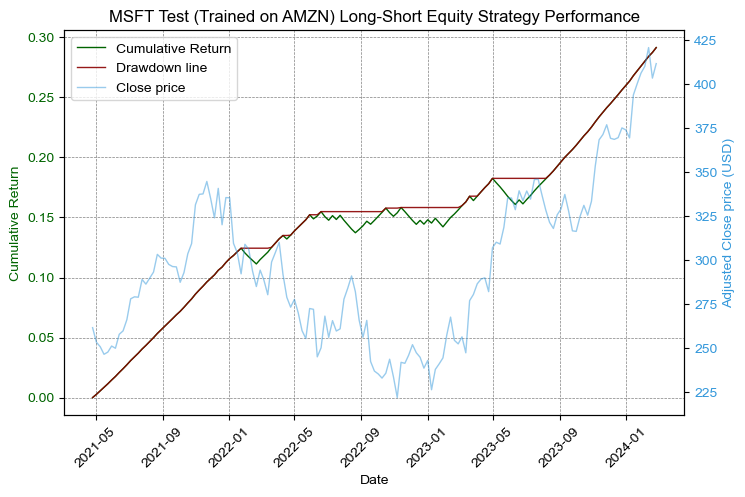

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 13.2 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 7 weeks
────────────────────────────────────────
Cumulative return over the period: 3.5 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 16 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 48.0 %
────────────────────────────────────────
Cumulative return over the period: 33.4 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 20 weeks
────────────────────────────────────────


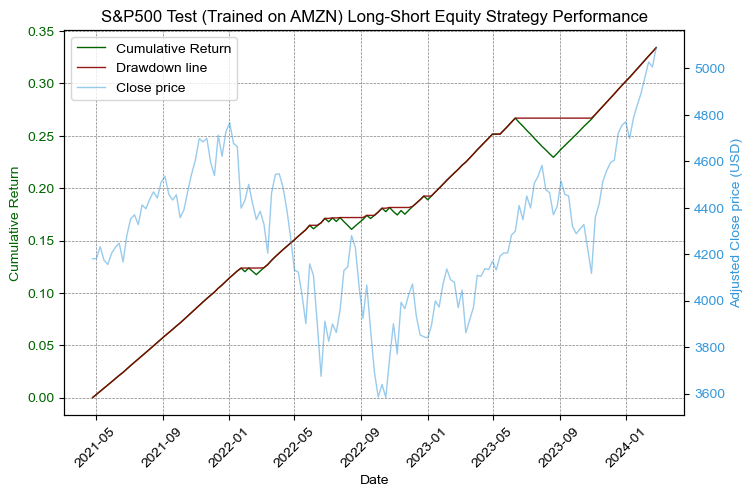

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.4 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 3 weeks
────────────────────────────────────────
Cumulative return over the period: 8.4 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 29.2 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 20 weeks
────────────────────────────────────────


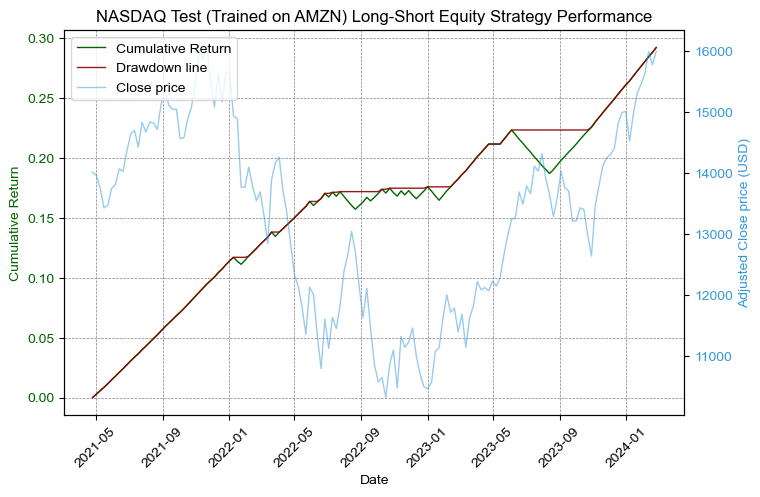

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.4 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 3 weeks
────────────────────────────────────────
Cumulative return over the period: 5.3 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 10 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 36.8 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 14 weeks
────────────────────────────────────────


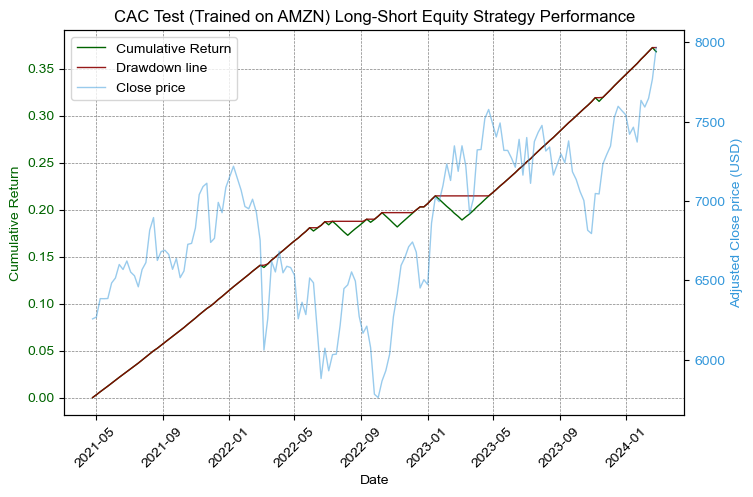

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.0 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 1 weeks
────────────────────────────────────────
Cumulative return over the period: 4.1 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 13 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [19]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')

# Create a dictionary for better readability and access
test_dfs = {
    ibm_name: ibm_test_df,
    msft_name: msft_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    cac_name: cac_test_df
}

for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on AMZN)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## MSFT dataset

### Training for 500 epochs, training size = 1339 cases
epoch    0: Loss=1.42728
epoch   10: Loss=1.00323
epoch   20: Loss=0.98902
epoch   30: Loss=0.98355
epoch   40: Loss=0.97850
epoch   50: Loss=0.97243
epoch   60: Loss=0.96922
epoch   70: Loss=0.96687
epoch   80: Loss=0.96504
epoch   90: Loss=0.96352
epoch  100: Loss=0.96222
epoch  110: Loss=0.96108
epoch  120: Loss=0.96008
epoch  130: Loss=0.95917
epoch  140: Loss=0.95834
epoch  150: Loss=0.95721
epoch  160: Loss=0.95593
epoch  170: Loss=0.95377
epoch  180: Loss=0.95183
epoch  190: Loss=0.94986
epoch  200: Loss=0.94788
epoch  210: Loss=0.94603
epoch  220: Loss=0.94436
epoch  230: Loss=0.94267
epoch  240: Loss=0.94116
epoch  250: Loss=0.93975
epoch  260: Loss=0.93845
epoch  270: Loss=0.93734
epoch  280: Loss=0.93652
epoch  290: Loss=0.93575
epoch  300: Loss=0.93489
epoch  310: Loss=0.93424
epoch  320: Loss=0.93341
epoch  330: Loss=0.93290
epoch  340: Loss=0.93251
epoch  350: Loss=0.93225
epoch  360: Loss=0.93211
epoch  370: Loss=0.

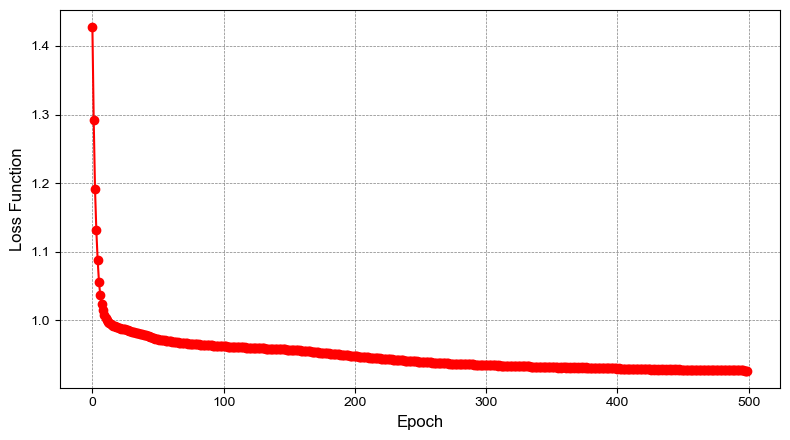

In [20]:
df=msft
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 53.0 %
────────────────────────────────────────


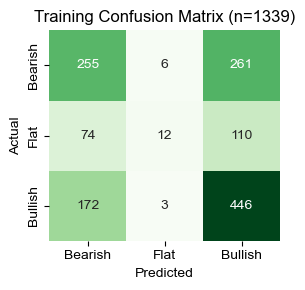

In [21]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 46.0 %
────────────────────────────────────────


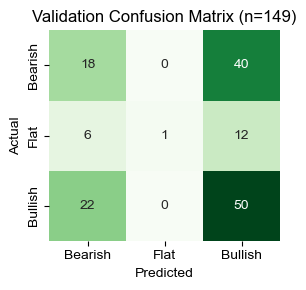

In [22]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 200633.4 %
Baseline Return (Buy and Hold over the period): 6875.7 %
Maximum Drawdown Duration 365 weeks


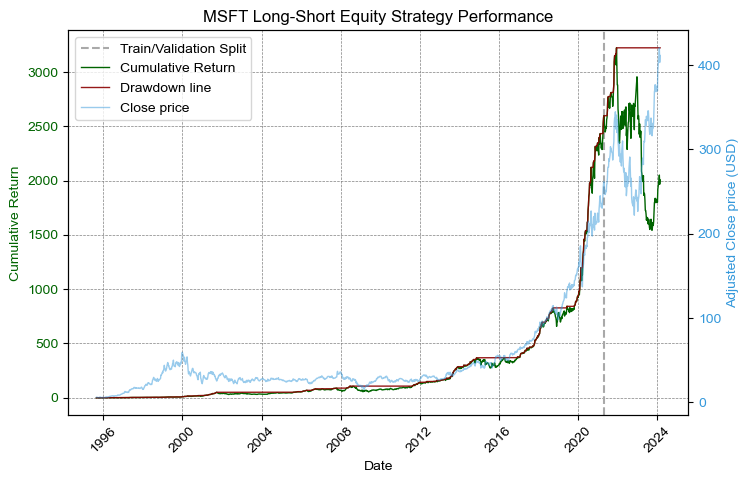

In [23]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'MSFT', train_test_split=0.9, save_figure=True)

Cumulative return over the period: -22.8 %
Baseline Return (Buy and Hold over the period): 57.2 %
Validation Set Maximum Drawdown: 115 weeks


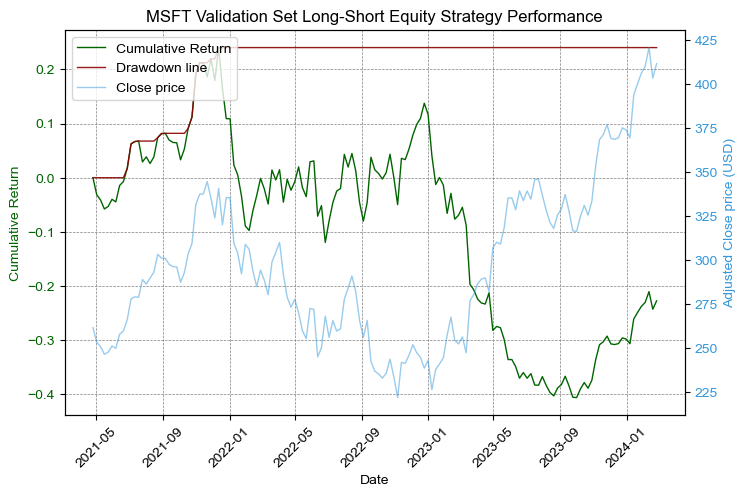

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -0.3 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 18 weeks
────────────────────────────────────────
Cumulative return over the period: -21.5 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 16 weeks
────────────────────────────────────────


In [24]:
split_idx=int(len(msft)*0.9)
msft_test_df=msft[split_idx:]
msft_test_df = utilities.calculate_returns(msft_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(msft_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(msft_test_df, 'MSFT Validation Set', save_figure=True)
utilities.calculate_yearly_returns(msft_test_df)

Cross-testing on IBM Test
Cross-Test Accuracy: 38.0 %
────────────────────────────────────────
Cumulative return over the period: -7.5 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 126 weeks
────────────────────────────────────────


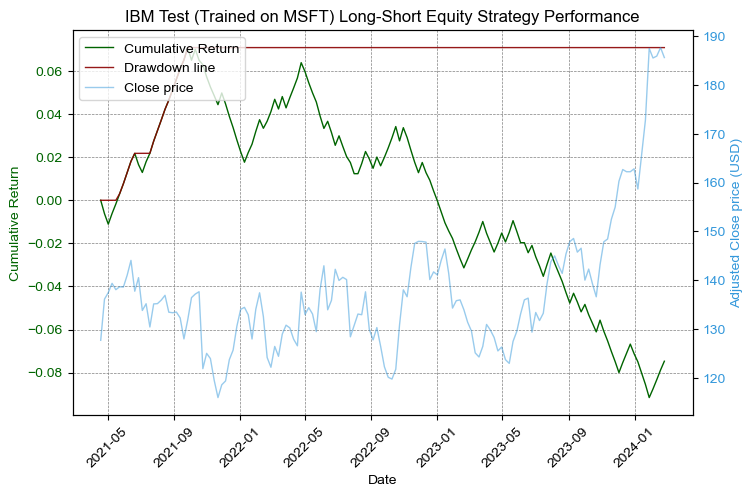

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 5.2 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 28 weeks
────────────────────────────────────────
Cumulative return over the period: -7.2 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 50 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on AMZN Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 12.0 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 81 weeks
────────────────────────────────────────


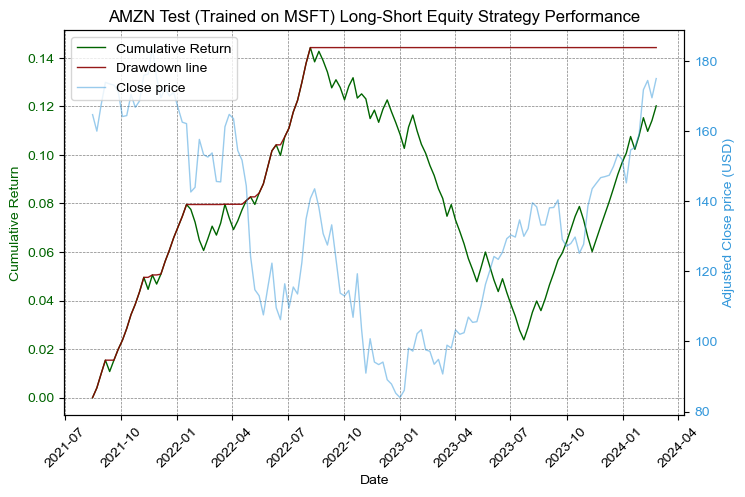

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.4 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
Cumulative return over the period: -9.1 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 50 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 29.2 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 67 weeks
────────────────────────────────────────


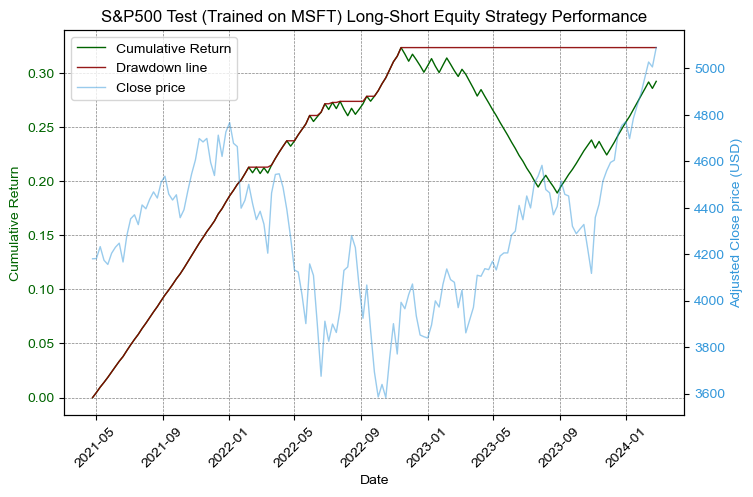

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 23.7 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 3 weeks
────────────────────────────────────────
Cumulative return over the period: 3.7 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 22 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 37.0 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 38 weeks
────────────────────────────────────────


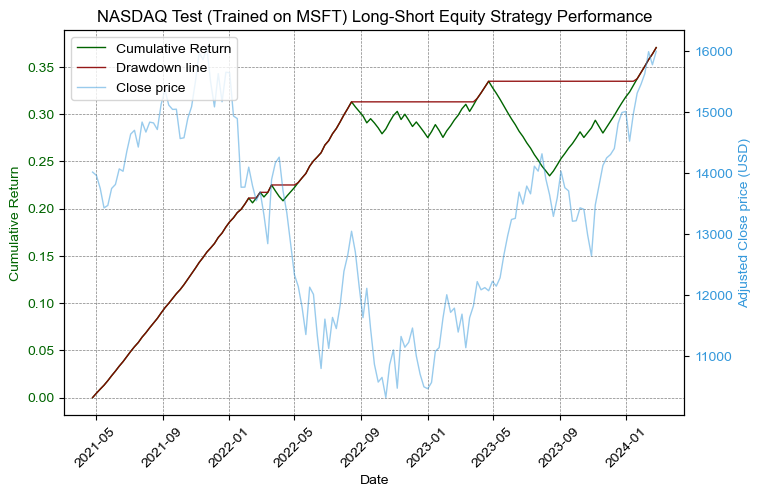

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 21.3 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
Cumulative return over the period: 9.1 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 32 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 21.7 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 38 weeks
────────────────────────────────────────


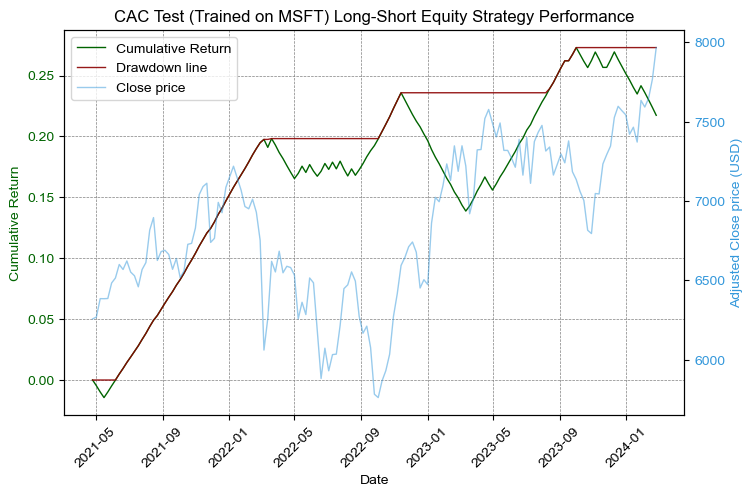

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 17.6 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
Cumulative return over the period: -0.3 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 22 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [25]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')

# Create a dictionary for better readability and access
test_dfs = {
    ibm_name: ibm_test_df,
    amzn_name: amzn_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    cac_name: cac_test_df
}

for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on MSFT)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## IBM dataset

### Training for 500 epochs, training size = 1342 cases
epoch    0: Loss=1.41697
epoch   10: Loss=1.09413
epoch   20: Loss=1.06274
epoch   30: Loss=1.04698
epoch   40: Loss=1.03758
epoch   50: Loss=1.03164
epoch   60: Loss=1.02764
epoch   70: Loss=1.02377
epoch   80: Loss=1.02042
epoch   90: Loss=1.01816
epoch  100: Loss=1.01633
epoch  110: Loss=1.01480
epoch  120: Loss=1.01320
epoch  130: Loss=1.01073
epoch  140: Loss=1.00851
epoch  150: Loss=1.00809
epoch  160: Loss=1.00287
epoch  170: Loss=1.00148
epoch  180: Loss=0.99932
epoch  190: Loss=0.99677
epoch  200: Loss=0.99402
epoch  210: Loss=0.98978
epoch  220: Loss=0.98697
epoch  230: Loss=0.98447
epoch  240: Loss=0.98219
epoch  250: Loss=0.97981
epoch  260: Loss=0.97760
epoch  270: Loss=0.97573
epoch  280: Loss=0.97416
epoch  290: Loss=0.97284
epoch  300: Loss=0.97172
epoch  310: Loss=0.97072
epoch  320: Loss=0.96974
epoch  330: Loss=0.96884
epoch  340: Loss=0.96833
epoch  350: Loss=0.96690
epoch  360: Loss=0.96644
epoch  370: Loss=0.

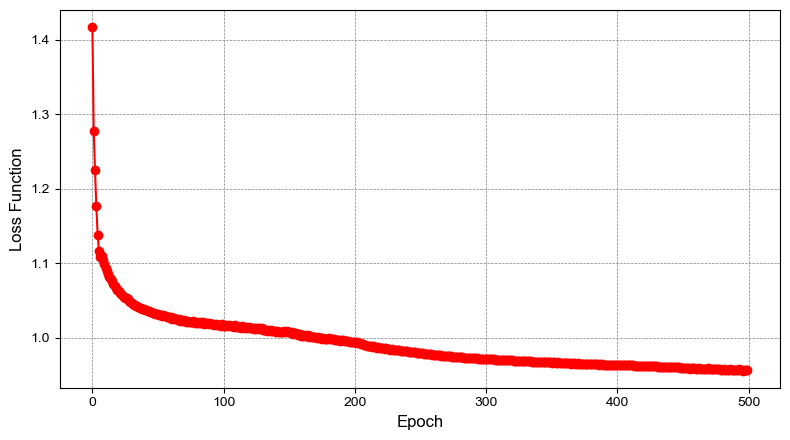

In [26]:
df=ibm
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 49.0 %
────────────────────────────────────────


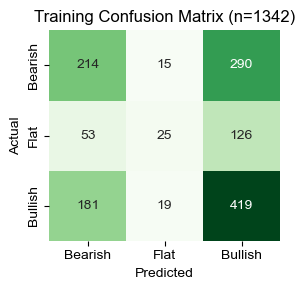

In [27]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 42.0 %
────────────────────────────────────────


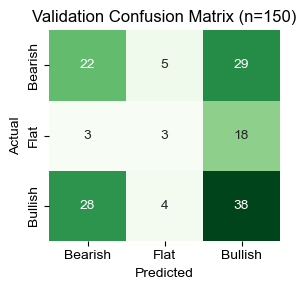

In [28]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 2059.8 %
Baseline Return (Buy and Hold over the period): 602.0 %
Maximum Drawdown Duration 365 weeks


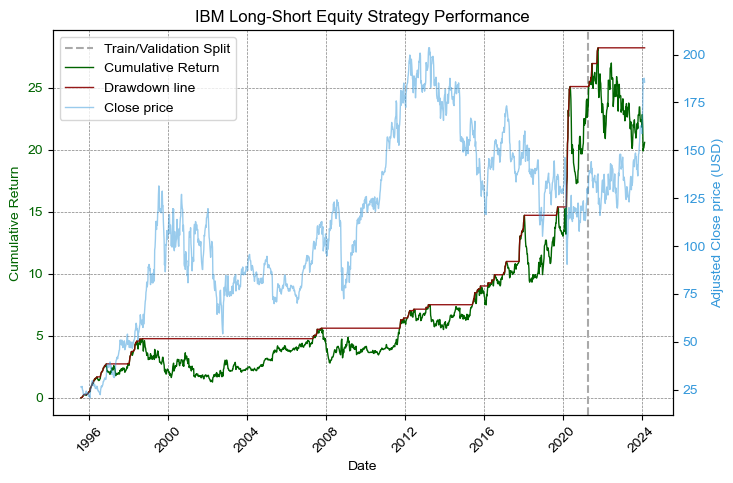

In [29]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'IBM', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 12.0 %
Baseline Return (Buy and Hold over the period): 6.2 %
Validation Set Maximum Drawdown: 81 weeks


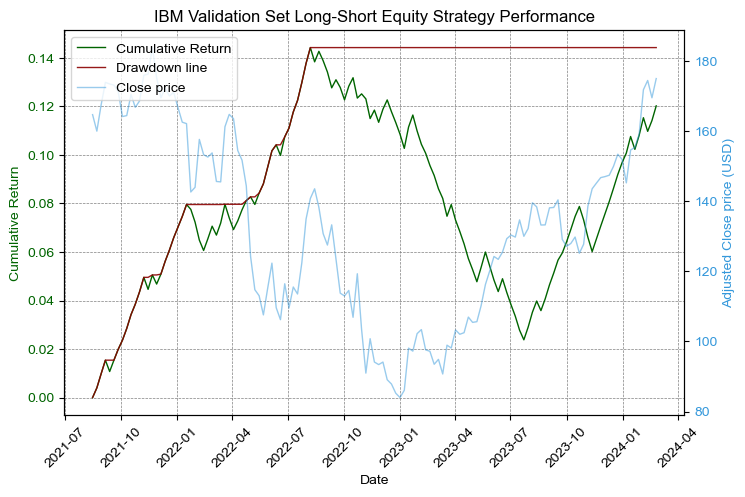

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.4 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
Cumulative return over the period: -9.1 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 50 weeks
────────────────────────────────────────


In [30]:
split_idx=int(len(ibm)*0.9)
ibm_test_df=ibm[split_idx:]
ibm_test_df = utilities.calculate_returns(amzn_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(ibm_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(ibm_test_df, 'IBM Validation Set', save_figure=True)
utilities.calculate_yearly_returns(ibm_test_df)

Cross-testing on MSFT Test
Cross-Test Accuracy: 49.0 %
────────────────────────────────────────
Cumulative return over the period: 22.3 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 76 weeks
────────────────────────────────────────


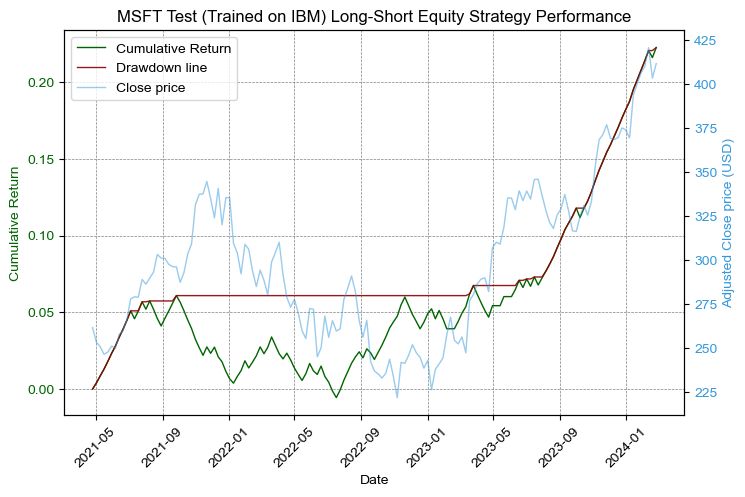

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 2.3 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 29 weeks
────────────────────────────────────────
Cumulative return over the period: 3.2 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 16 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on AMZN Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 14.8 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 72 weeks
────────────────────────────────────────


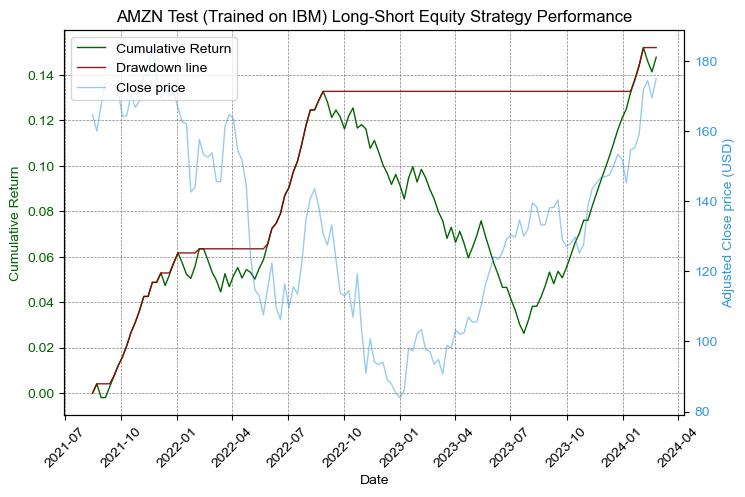

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 12.5 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 14 weeks
────────────────────────────────────────
Cumulative return over the period: -7.7 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 49 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 56.7 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 13 weeks
────────────────────────────────────────


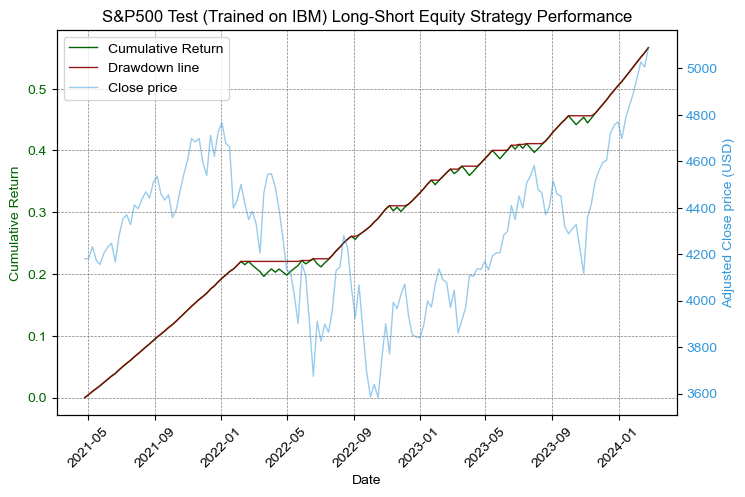

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 20.8 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
Cumulative return over the period: 14.1 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 51.3 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 19 weeks
────────────────────────────────────────


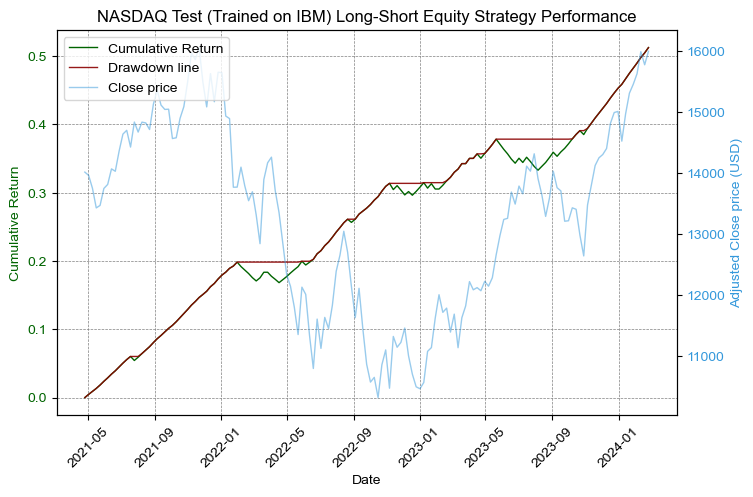

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.8 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 11 weeks
────────────────────────────────────────
Cumulative return over the period: 15.7 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 50.0 %
────────────────────────────────────────
Cumulative return over the period: 48.1 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 29 weeks
────────────────────────────────────────


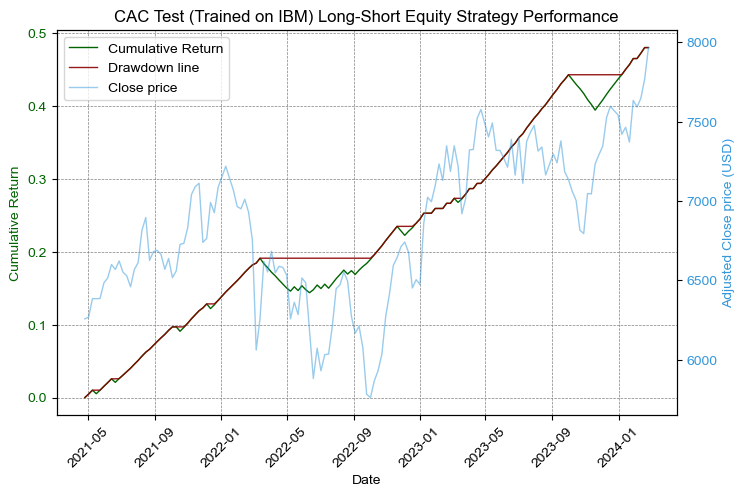

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.1 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 5 weeks
────────────────────────────────────────
Cumulative return over the period: 12.0 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 10 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [31]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')

# Create a dictionary for better readability and access
test_dfs = {
    msft_name: msft_test_df,
    amzn_name: amzn_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    cac_name: cac_test_df
}
    
for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on IBM)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## CAC dataset

In [32]:
df=cac
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

### Training for 500 epochs, training size = 1341 cases
epoch    0: Loss=1.36389
epoch   10: Loss=1.09885
epoch   20: Loss=1.05076
epoch   30: Loss=1.04067
epoch   40: Loss=1.02421
epoch   50: Loss=1.01706
epoch   60: Loss=1.01386
epoch   70: Loss=1.00916
epoch   80: Loss=1.00440
epoch   90: Loss=1.00385
epoch  100: Loss=1.00328
epoch  110: Loss=0.99795
epoch  120: Loss=1.00330
epoch  130: Loss=0.99589
epoch  140: Loss=0.99333
epoch  150: Loss=0.99087
epoch  160: Loss=0.98976
epoch  170: Loss=0.98984
epoch  180: Loss=0.98750
epoch  190: Loss=0.98902
epoch  200: Loss=0.98449
epoch  210: Loss=0.98158
epoch  220: Loss=0.98291
epoch  230: Loss=0.97705
epoch  240: Loss=0.97527
epoch  250: Loss=0.97363
epoch  260: Loss=0.97255
epoch  270: Loss=0.97087
epoch  280: Loss=0.97394
epoch  290: Loss=0.96699
epoch  300: Loss=0.96372
epoch  310: Loss=0.96569
epoch  320: Loss=0.95983
epoch  330: Loss=0.95960
epoch  340: Loss=0.96666
epoch  350: Loss=0.95725
epoch  360: Loss=0.96007
epoch  370: Loss=0.

KeyboardInterrupt: 

In [ ]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

In [ ]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

In [ ]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'CAC', train_test_split=0.9, save_figure=True)

In [ ]:
split_idx=int(len(cac)*0.9)
cac_test_df=cac[split_idx:]
cac_test_df = utilities.calculate_returns(cac_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(cac_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(cac_test_df, 'CAC Validation Set', save_figure=True)
utilities.calculate_yearly_returns(cac_test_df)

In [ ]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')

# Create a dictionary for better readability and access
test_dfs = {
    msft_name: msft_test_df,
    amzn_name: amzn_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    ibm_name: ibm_test_df
}
    
for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on CAC)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## S&P500 dataset

In [ ]:
df=sp500
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

In [ ]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

In [ ]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

In [ ]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'S&P500', train_test_split=0.9, save_figure=True)

In [ ]:
split_idx=int(len(sp500)*0.9)
sp500_test_df=sp500[split_idx:]
sp500_test_df = utilities.calculate_returns(sp500_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(sp500_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(sp500_test_df, 'S&P500 Validation Set', save_figure=True)
utilities.calculate_yearly_returns(sp500_test_df)

In [ ]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')

# Create a dictionary for better readability and access
test_dfs = {
    msft_name: msft_test_df,
    amzn_name: amzn_test_df,
    cac_name: cac_test_df,
    nasdaq_name: nasdaq_test_df,
    ibm_name: ibm_test_df
}
    
for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on S&P500)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## NASDAQ dataset

In [ ]:
df=nasdaq
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

In [ ]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

In [ ]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

In [ ]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'NASDAQ', train_test_split=0.9, save_figure=True)

In [ ]:
split_idx=int(len(nasdaq)*0.9)
nasdaq_test_df=nasdaq[split_idx:]
nasdaq_test_df = utilities.calculate_returns(nasdaq_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(nasdaq_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(nasdaq_test_df, 'NASDAQ Validation Set', save_figure=True)
utilities.calculate_yearly_returns(nasdaq_test_df)

In [ ]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')

# Create a dictionary for better readability and access
test_dfs = {
    msft_name: msft_test_df,
    amzn_name: amzn_test_df,
    cac_name: cac_test_df,
    sp500_name: sp500_test_df,
    ibm_name: ibm_test_df
}
    
for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on NASDAQ)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─'*100)